In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
IMG_PATH = "data/Medical Mask/images"

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("submission.csv")
display(train.head())
display(test.head())

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


,name,x1,x2,y1,y2,classname
0,1800.jpg,NaN,NaN,NaN,NaN,NaN
1,1800.jpg,NaN,NaN,NaN,NaN,NaN
2,1800.jpg,NaN,NaN,NaN,NaN,NaN
3,1799.jpg,NaN,NaN,NaN,NaN,NaN
4,1799.jpg,NaN,NaN,NaN,NaN,NaN


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15412 entries, 0 to 15411
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       15412 non-null  object
 1   x1         15412 non-null  int64 
 2   x2         15412 non-null  int64 
 3   y1         15412 non-null  int64 
 4   y2         15412 non-null  int64 
 5   classname  15412 non-null  object
dtypes: int64(4), object(2)
memory usage: 722.6+ KB


In [5]:
train.isnull().sum()

name         0
x1           0
x2           0
y1           0
y2           0
classname    0
dtype: int64

In [6]:
classes = train["classname"].unique()
classes

array(['face_with_mask', 'mask_colorful', 'face_no_mask',
       'face_with_mask_incorrect', 'mask_surgical', 'face_other_covering',
       'scarf_bandana', 'eyeglasses', 'helmet', 'face_shield',
       'sunglasses', 'hood', 'hat', 'goggles', 'hair_net', 'hijab_niqab',
       'other', 'gas_mask', 'balaclava_ski_mask', 'turban'], dtype=object)

As evaluation will be done on the basis of face_with_mask and face_no_mask\
Assumption for sake of simplicity a Surgical Mask & Mask Colorful is equivalent to having a mask on and having mask incorrectly or any other class is equivalent to not having a mask on\
Training on all parameters took too long on local machine selected following ROI size and params to train the model faster given the time constraint\
Selected a ROI of 100x100

In [7]:
mask = ["face_with_mask", "mask_surgical"]
# no_mask = [class_name for class_name in classes if class_name not in mask]
no_mask = ["face_no_mask"]
classes_to_retain = mask+no_mask
mask, no_mask

(['face_with_mask', 'mask_surgical'], ['face_no_mask'])

In [8]:
train = train[train["classname"].isin(classes_to_retain)]
for class_name in mask:
    if class_name == "face_with_mask":
        continue
    train["classname"] = train["classname"].replace(class_name, "face_with_mask")
for class_name in no_mask:
    if class_name == "face_no_mask":
        continue
    train["classname"] = train["classname"].replace(class_name, "face_no_mask")

<Axes: xlabel='classname', ylabel='Count'>

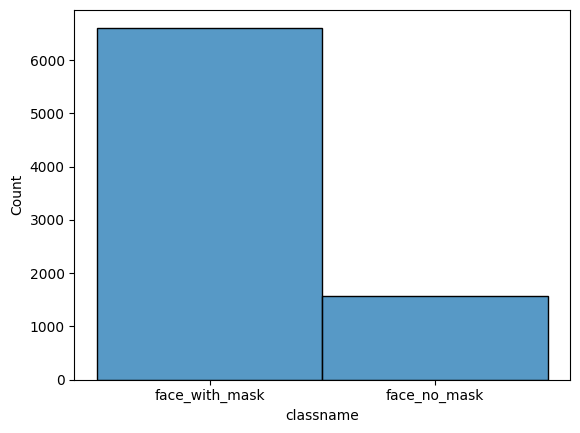

In [9]:
sns.histplot(data=train, x="classname")

In [10]:
train.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
4,6098.jpg,360,85,728,653,face_no_mask
6,6427.png,278,386,582,582,face_with_mask
7,4591.png,239,9,522,342,face_with_mask


In [11]:
train.shape

(8179, 6)

name               2756.png
x1                       69
x2                      126
y1                      294
y2                      392
classname    face_with_mask
Name: 0, dtype: object


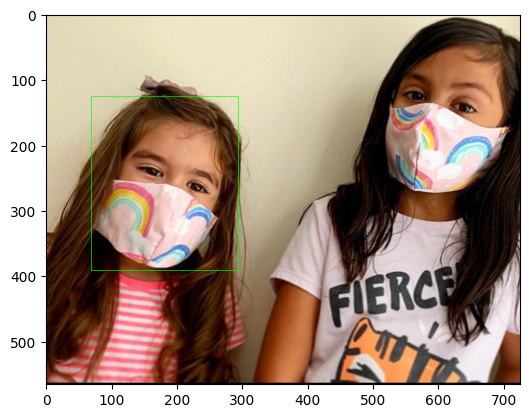

In [12]:
# seems like
# ymin(y1) should be x2
# xmax(x2) should be y1

x = train.iloc[0]
print(x)
img = cv2.imread(os.path.join(IMG_PATH, x["name"]))
cv2.rectangle(img, (x["y1"], x["y2"]), (x["x1"], x["x2"]), (0, 255, 0), 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### fixing headers for bbox coords

In [13]:
train.rename({"y1": "x2", "x2": "y1"}, axis=1, inplace=True)

In [14]:
train.shape

(8179, 6)

In [15]:
train.head()

,name,x1,y1,x2,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
4,6098.jpg,360,85,728,653,face_no_mask
6,6427.png,278,386,582,582,face_with_mask
7,4591.png,239,9,522,342,face_with_mask


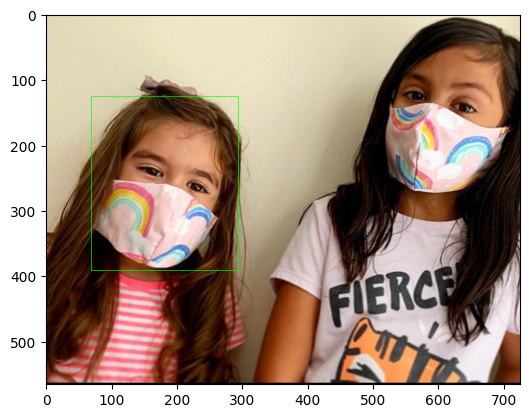

In [16]:
x = train.iloc[0]
img = cv2.imread(os.path.join(IMG_PATH, x["name"]))
cv2.rectangle(img, (x["x1"], x["y1"]), (x["x2"], x["y2"]), (0, 255, 0), 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Get Region of Interest (faces)

In [17]:
def get_roi(img, roi_size, xmin, ymin, xmax, ymax):
    roi = img[ymin:ymax, xmin:xmax]
    roi = cv2.resize(roi, roi_size)
    return cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

In [18]:
roi_size = (100, 100)  # 100x100

# index 8131
train["roi"] = None
image_data = []

for index, row in train.iterrows():
    print("Processing Index: ", index)
    try:
        img = cv2.imread(os.path.join(IMG_PATH, row["name"]))
        # Check if the image was loaded
        if img is None:
            print("Error Image not found")
            raise ValueError(
                f"Image not found at {os.path.join(IMG_PATH, row['name'])}"
            )
        roi = get_roi(img, roi_size, row["x1"], row["y1"], row["x2"], row["y2"])
        train.at[index, "roi"] = roi
        image_data.append(roi)
    except Exception as e:  # index 8131
        train.at[index, "classname"] = "drop"
        train.at[index, "data"] = 0

Processing Index:  0
Processing Index:  1
Processing Index:  4
Processing Index:  6
Processing Index:  7
Processing Index:  11
Processing Index:  12
Processing Index:  13
Processing Index:  16
Processing Index:  17
Processing Index:  19
Processing Index:  20
Processing Index:  21
Processing Index:  22
Processing Index:  23
Processing Index:  25
Processing Index:  33
Processing Index:  35
Processing Index:  37
Processing Index:  38
Processing Index:  39
Processing Index:  40
Processing Index:  41
Processing Index:  42
Processing Index:  44
Processing Index:  46
Processing Index:  49
Processing Index:  50
Processing Index:  52
Processing Index:  53
Processing Index:  54
Processing Index:  57
Processing Index:  58
Processing Index:  59
Processing Index:  60
Processing Index:  62
Processing Index:  64
Processing Index:  65
Processing Index:  68
Processing Index:  70
Processing Index:  72
Processing Index:  73
Processing Index:  76
Processing Index:  80
Processing Index:  81
Processing Inde

In [19]:
# Remove rows which gave problems
train.drop(train.loc[train["classname"] == "drop"].index, inplace=True)

In [20]:
# Lable Encoding

mappings = {
    "face_with_mask": 1,
    "face_no_mask": 0,
}

train["classname"] = train["classname"].map(mappings)

### Export Data

In [21]:
# Save Fixed DF
train_save = train.drop(columns=["roi"], axis=1)
train_save.to_csv("fixed_train.csv", index=False)

In [22]:
X = train["roi"].to_numpy()
X = np.stack(X)
Y= train["classname"].astype(np.int32).to_numpy()
Y = np.reshape(Y, (Y.shape[0], 1))

In [23]:
X.shape, Y.shape

((8179, 100, 100, 3), (8179, 1))

In [ ]:
if not os.path.exists("npy"):
    os.makedirs("npy")

In [24]:
with open("npy/X.npy", "wb") as f:
    np.save(f, X)
with open("npy/Y.npy", "wb") as f:
    np.save(f, Y)

In [25]:
load_X = np.load("npy/X.npy")
load_Y = np.load("npy/Y.npy")

In [26]:
print(load_X)

[[[[224 213 183]
   [224 213 183]
   [224 213 183]
   ...
   [235 226 195]
   [235 226 195]
   [235 226 195]]

  [[224 213 183]
   [224 213 183]
   [224 213 183]
   ...
   [234 225 194]
   [234 225 194]
   [234 225 194]]

  [[223 212 184]
   [223 212 184]
   [222 211 183]
   ...
   [233 224 193]
   [234 225 194]
   [235 226 195]]

  ...

  [[ 33   4   1]
   [ 31  11   7]
   [ 14   5   3]
   ...
   [143 115  85]
   [137 112  82]
   [160 136 110]]

  [[ 33  10   6]
   [ 22   7   4]
   [ 10   2   1]
   ...
   [142 112  81]
   [134 108  78]
   [156 134 103]]

  [[ 37  16  12]
   [ 19   3   3]
   [ 11   0   1]
   ...
   [137 105  74]
   [137 111  80]
   [155 133 101]]]


 [[[226 217 186]
   [226 217 186]
   [226 217 186]
   ...
   [234 223 192]
   [234 223 191]
   [233 223 188]]

  [[226 217 187]
   [225 217 187]
   [225 217 187]
   ...
   [234 224 191]
   [234 223 190]
   [233 223 188]]

  [[224 216 188]
   [224 217 188]
   [225 218 189]
   ...
   [235 225 190]
   [234 224 189]
   [233 223